In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
A = 3.81

rms_a, rms_b, rms_c =  -0.01488638, -0.52343314, -3.94385739

band = 'w1'
param = 'a'
## Luminosity function parameters
alpha = -1
Ms = -21.9

## TF realtion parameters
slope = -9.47
zp = -20.36
rms = 0.58


Mlim = -16.1 # getMagLim(slope, zp, band = band)
print band
print "Mag. Limit:", '%.2f'%Mlim

w1
Mag. Limit: -16.10


In [4]:
####################################
def CurveFUN(x, A):

    logW0 = 2.5

    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x

    X0 = logW0 - 2.5
    X = logW-2.5

    B = -2.*A*X0

    M = slope*X+zp-0.08
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

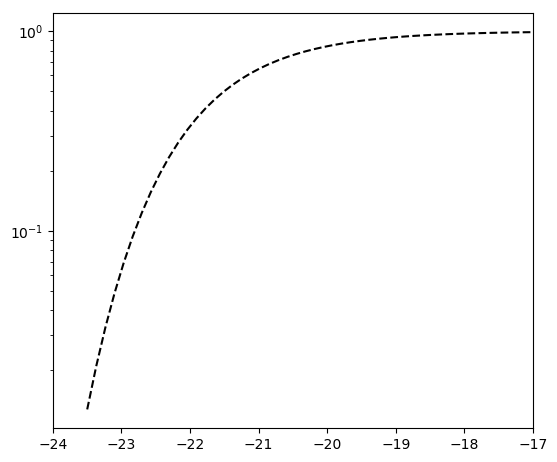

In [5]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

0.577954143166979


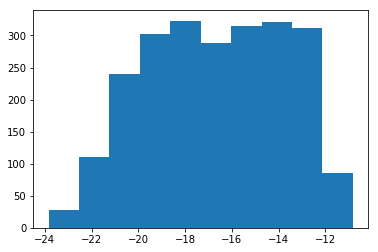

In [6]:
np.random.seed(0)

size = 3000
randMGAG = np.random.uniform(low=-24, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

simulMag  = randMGAG[indx]
simulWimx = (simulMag-zp)/slope + 2.5
N = len(simulMag)
scatterMAG = np.random.normal(0, rms, N)
simulMag += scatterMAG


# print randMGAG
# print randU
plt.hist(simulMag)
print np.std(scatterMAG)

0.6188532410460215


Text(2.5,-17.4,'M$_{lim}=-17$  mag')

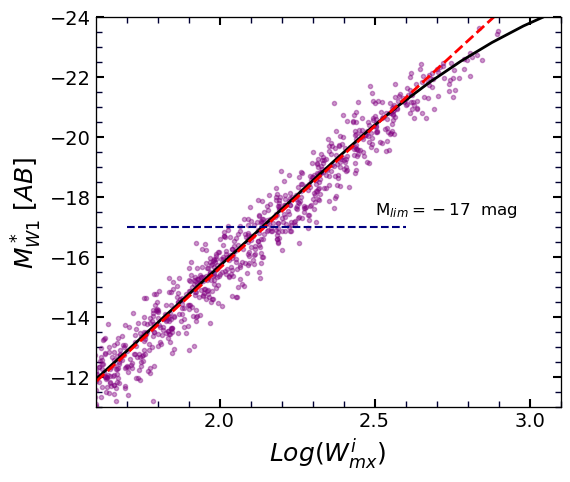

In [13]:
def myCurve(x, a, b, c):
    
    x0 = -b/2./a
    y = a*x**2+b*x+c
    
    indx, = np.where(x>=x0)
    y[indx] = a*x0**2+b*x0+c
    
    indx, = np.where(x<-21)
    x0 = -21.
    y[indx] = a*x0**2+b*x0+c
    
    return y

########################################################

def curveSimul(A, Ms, alpha, mag_scatter=True, size=100000, seed=0):
    
    
    if band in ['w1', 'w2']:
        logW0=2.4
    else:
        logW0=2.5

    logW = x
    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+zp-0.08
    M0 = slope*X0+zp-0.08
    
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))
    
    A0 = A
    B0 = B+slope
    C0 = zp - (A*X0**2+B*X0)
    
    np.random.seed(seed)
    
    randMGAG = np.random.uniform(low=-28, high=-10, size=size*10)
    randU = np.random.uniform(low=0, high=1, size=size*10)
    randLfunct = LFfunction(randMGAG, Ms, alpha)
    indx, = np.where(randU<randLfunct)
    simulMag  = randMGAG[indx]
    simulWimx1 = (simulMag-zp)/slope+2.5
    
    simulWimx2 = np.array([np.min(np.roots([A0, B0, C0-Msim])+2.5) for Msim in simulMag])
    
    simulWimx = simulWimx1*0.
    for i, Msim in enumerate(simulMag):
        if Msim<M0:
            simulWimx[i] = simulWimx2[i]
        else:
            simulWimx[i] = simulWimx1[i]
    
#     
    
    real_mag  = simulMag[:size]
    simulWimx = simulWimx[:size]
    
    
    ## scattring along the magnitude axis
    N = len(real_mag)
    
    rms_mag = myCurve(real_mag, rms_a, rms_b, rms_c)
    
    if mag_scatter:
        for i in range(len(real_mag)):
            real_mag[i] += np.random.normal(0, rms_mag[i])
    simulMag = real_mag
    
    return simulMag, simulWimx
    
########################################################

fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

x = np.linspace(-5,5,100)
y = CurveFUN(x, A)
yl = slope*(x-2.5)+zp 
    
simulMag, simulWimx = curveSimul(A, Ms, alpha, 
               mag_scatter=True, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color=dye[band], alpha=0.4)
print np.std(simulMag-(slope*(simulWimx-2.5)+zp))


ax.plot(x,y, 'k-', lw=2) 
ax.plot(x,yl, 'r--', lw=2) 

x = np.linspace(1.7,2.6,20)
ax.plot(x,-17+(0*(x-2.5)+0),'--', lw=1.5, color='navy')      


ax.text(2.5, -17.4, 'M'+r'$_{lim}=-17$'+'  mag', fontsize=12, color='k')

In [8]:
def simulClusterOBS(Mlim_lst, slope, zp, 
                        simulMag, simulWimx):
    
    
    delta_lst = Mlim_lst*0.    
    
    for i, Mlim in enumerate(Mlim_lst):   
        
        indx, = np.where(simulMag<Mlim)
        
        
        simulMag_obs = simulMag[indx]
        simulWimx_obs = simulWimx[indx]
        simulMag_real = CurveFUN(simulWimx_obs, A)
#         slope*(simulWimx_obs-2.5)+zp
      
        # real mag - observed mag
        bias = simulMag_real-simulMag_obs 
          
        delta_lst[i] = np.median(bias)
    

    return delta_lst

#########################################################

Mlim = -17

n_simul = 50
M0_C = np.arange(Mlim,Mlim-7.0,-0.5)


#########################################################


n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    simulMag, simulWimx = curveSimul(A, Ms, alpha, 
               mag_scatter=True, size=20000, seed=i)
    outputs[i] = simulClusterOBS(M0_C, slope, zp, simulMag, simulWimx)
    
    if i%5==0:
        print i

    
bias_CM = np.median(outputs, 0)
bias_err_CM = np.std(outputs, 0)


print bias_CM


0
5
10
15
20
25
30
35
40
45
[0.00904613 0.017148   0.02732734 0.03871305 0.05025162 0.06356404
 0.08286956 0.10265282 0.13869743 0.18797059 0.24917422 0.34652804
 0.4440156  0.57817036]


In [9]:
N = len(bias_CM)
bias_CM0 = bias_CM
bias_err_CM0 = bias_err_CM

M0_C = np.arange(Mlim,Mlim-7.0,-0.5)


In [10]:
def add2Dict(myDict, code, band, param, DM):
    
    if not code in myDict:
        myDict[code]={}
    if not band in myDict[code]:
        myDict[code][band]={}
    if not param in myDict[code][band]:
        myDict[code][band][param]={}
    myDict[code][band][param] = DM
##############################################   
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims = table[band]
code = table['Code']  
##############################################
table   = np.genfromtxt('cluster_DM_code.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
DM_band = table['band']
DM_param = table['param']
DM_code = table['Code']
DM = table['DM']
##############################################
    
DM_Dict = {}    
for i, myCode in enumerate(DM_code):
    add2Dict(DM_Dict, myCode.strip(), DM_band[i].strip(), DM_param[i].strip(), np.float(DM[i])) 
    
print DM_Dict['V']['z']['a']

30.91


In [11]:
print Mlim

-17


0.04$\pm$0.01 & -0.15$\pm$0.07 & 0.31$\pm$0.22 & 1.65$\pm$0.23 & 
[ 0.00041804 -0.00145266  0.0031477   0.01652154]


Text(-16.6,0.6,'M$_{lim}=-17$  mag')

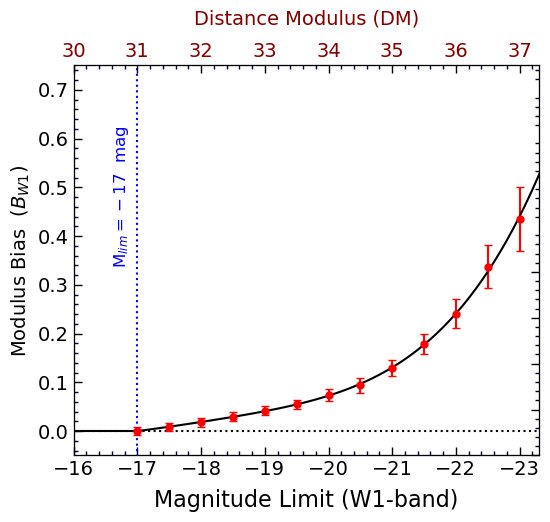

In [12]:
# def biasFuc2(M, a, b):
#     return a*(np.abs(M+17))**b

def biasFuc2(M, a, b, c, d):
    X = np.abs(M-Mlim)
#     return a*X**5+b*X**4+c*X**3+d*X**2+e*X
    return a*X**4+b*X**3+c*X**2+d*X


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot([-12,-25],[0,0], 'k:')


ax.errorbar(M0_C , bias_CM0-bias_CM0[0], yerr=bias_err_CM0, fmt='o', color='r', capsize=3, markersize=5)


fit, cov = curve_fit(biasFuc2, M0_C , bias_CM0-bias_CM0[0], sigma=bias_err_CM0)


st = ''
for i, ff in enumerate(fit):
    st += '%.2f'%(ff*100) + '$\pm$' + '%.2f'%(np.sqrt(cov[i][i])*100) + ' & '
print st
print fit 

m = np.arange(M0_C[0],-24,-0.1)
ax.plot(m, biasFuc2(m, fit[0], fit[1], fit[2], fit[3]), 'k-')
ax.plot([-10, Mlim],[0,0], 'k-')


x_ax, y_ax = set_axes(ax, xlim=(-16,-23.3), ylim=(-0.05,0.75), fontsize=14)
y_ax.set_yticks(np.arange(-0.1, 0.35, step=0.1))
x_ax.set_xlim(30,37.3)
x_ax.set_xticks(np.arange(30,38, 1))
x_ax.set_xticklabels(np.arange(30,38, 1), color='maroon')
x_ax.tick_params(labelsize=14)

ax.set_xlabel('Magnitude Limit', fontsize=14)
ax.set_ylabel('Modulus Bias  '+ r'$(B_{W1})$' , fontsize=14)
band_label = band
if band=='w1' or band=='w2':
    band_label = band.upper()
ax.set_xlabel('Magnitude Limit ('+band_label+'-band)', fontsize=16, labelpad=7)


# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.8*Xlm[0]+0.2*Xlm[1]
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$\rho = $"+"%.3f" % fit[0]+'$\pm$'+"%.3f" % np.sqrt(cov[0][0]), fontsize=14, color='k')
# y0 = 0.3*Ylm[0]+0.7*Ylm[1]
# ax.text(x0,y0, r"$\gamma = $"+"%.2f" % fit[1]+'$\pm$'+"%.2f" % np.sqrt(cov[1][1]), fontsize=14, color='k')

ax.plot([Mlim,Mlim], [-0.15,-0.1], 'b:')
ax.plot([Mlim,Mlim], [-1,1], 'b:')

x_ax.set_xlabel("Distance Modulus (DM)", fontsize=14, color='maroon')
x_ax.xaxis.labelpad = 12


ax.text(-16.6, 0.6, 'M'+r'$_{lim}=-17$'+'  mag', fontsize=12, color='b', rotation=90)